In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
events = pd.read_csv('Floods Listing - Flood IDs.csv')[['FEMA Disaster Code', 'FEMA Event Name', 'USGS Flood Event Name']]

In [3]:
applicants = pd.read_csv('GeoPublicAssistanceApplicants.csv')
applicants.drop(columns = ['hash','lastRefresh','id'], inplace = True)

In [4]:
grants = pd.read_csv('PublicAssistanceFundedProjectsDetails.csv')
grants.drop(columns = ['hash','lastRefresh','id'], inplace = True)

In [5]:
grants = pd.merge(left = grants, right = applicants, how = 'inner', left_on = ['applicantId', 'disasterNumber'], right_on = ['applicantId', 'disasterNumber'], suffixes = ('_grant', '_applicant'))

In [6]:
grants.drop(index = grants[grants['totalObligated'] < 0].index, inplace = True)

In [7]:
floods = pd.read_csv('Hurricane.csv')

In [8]:
floods.describe()[['latitude', 'longitude']]

,latitude,longitude
count,7869.000000,7869.000000
mean,32.860415,-83.343491
std,5.116649,8.965534
min,17.955220,-97.698700
25%,29.752204,-94.562200
50%,31.531078,-80.964310
75%,35.183084,-76.624111
max,44.057190,-65.630550


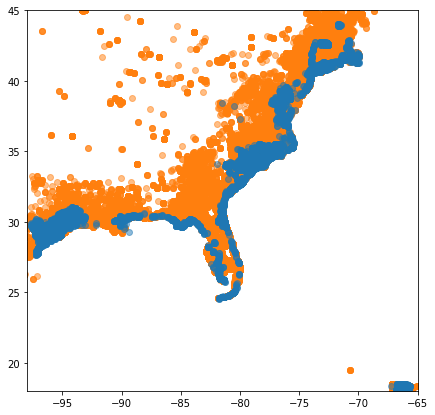

In [9]:
plt.figure(figsize = (7,7))
plt.ylim(18, 45)
plt.xlim(-98, -65)
plt.scatter(grants['longitude'], grants['latitude'], color = 'tab:orange', alpha = 0.5)
plt.scatter(floods['longitude'], floods['latitude'], color = 'tab:blue', alpha = 0.5)

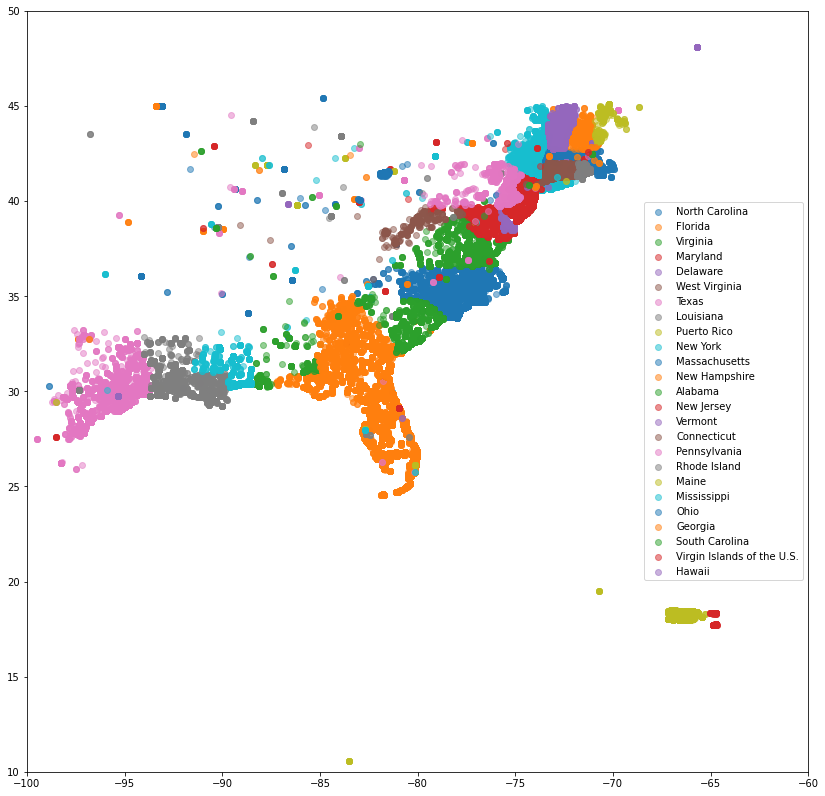

In [10]:
plt.figure(figsize = (14,14))
plt.ylim(10, 50)
plt.xlim(-100, -60)
for state in grants['state_grant'].unique():
    plt.scatter(grants[grants['state_grant'] == state]['longitude'], grants[grants['state_grant'] == state]['latitude'], alpha = 0.5, label = state)
plt.legend()

In [11]:
def outliers_index(dataframe, target_column):
    return dataframe[np.abs(dataframe[target_column] - dataframe[target_column].mean()) / dataframe[target_column].std() > 3].index

In [12]:
def plot_side_by_side(event, event_flood, event_grant):
    
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19, 7))
        plt.suptitle(event, fontsize = 14)

        ax[0].set_title('Observed Flood Height')
        left = ax[0].scatter(x = event_flood.drop(index = outliers_index(event_flood, 'height_above_gnd'))['longitude'], 
                      y = event_flood.drop(index = outliers_index(event_flood, 'height_above_gnd'))['latitude'], 
                      c = event_flood.drop(index = outliers_index(event_flood, 'height_above_gnd'))['height_above_gnd'],
                             cmap = 'YlGnBu')
        fig.colorbar(left, ax = ax[0], label = 'Feet')
        ax[0].set_axis_off()

        ax[1].set_title('FEMA Funding')
        right = ax[1].scatter(x = event_grant.drop(index = outliers_index(event_grant, 'totalObligated'))['longitude'], 
                      y = event_grant.drop(index = outliers_index(event_grant, 'totalObligated'))['latitude'],
                      c = event_grant.drop(index = outliers_index(event_grant, 'totalObligated'))['totalObligated'],
                             cmap = 'YlGnBu')
        fig.colorbar(right, ax = ax[1], label = '$')
        ax[1].set_axis_off()
        
        ax[0].set_xlim(ax[1].get_xlim())
        ax[0].set_ylim(ax[1].get_ylim())
        
        plt.savefig(f'images/{event}_side_by_side.jpg')
        plt.close()

In [13]:
def plot_densities(event, event_flood, event_grant):
    
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19, 7))
        plt.suptitle(event, fontsize = 14)

        ax[0].set_title('Flood Measurements')
        ax[0].hist2d(x =event_flood.drop(index = outliers_index(event_flood, 'height_above_gnd'))['longitude'], 
                      y = event_flood.drop(index = outliers_index(event_flood, 'height_above_gnd'))['latitude'],
                    bins = 20)
        ax[0].set_axis_off()

        ax[1].set_title('FEMA Grants')
        ax[1].hist2d(x = event_grant.drop(index = outliers_index(event_grant, 'totalObligated'))['longitude'], 
                      y = event_grant.drop(index = outliers_index(event_grant, 'totalObligated'))['latitude'],
                     bins = 20)
        ax[1].set_axis_off()
        
        ax[0].set_xlim(ax[1].get_xlim())
        ax[0].set_ylim(ax[1].get_ylim())
        
        plt.savefig(f'images/{event}_densities.jpg')
        plt.close()

In [14]:
def plot_hists(event, event_flood, event_grant):
    try:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19, 7))
        plt.suptitle(event, fontsize = 14)

        ax[0].hist(event_flood[event_flood['height_above_gnd'] < 12]['height_above_gnd'], bins = 'sqrt')
        ax[0].set_xlim(0, 12)
        ax[0].set_title('Observed Flood Height')
        ax[0].set_xlabel('Feet')

        ax[1].hist(event_grant[event_grant['totalObligated'] < 500_000]['totalObligated'], bins = 'sqrt')
        ax[1].set_xlim(0, 500_000)
        ax[1].set_title('FEMA Funding')
        ax[1].set_xlabel('$')

        plt.savefig(f'images/{event}_histograms.jpg')
        plt.close()
        
    except:
        pass

In [64]:
# The proximity of the closest severe flood to a point
def severe_prox(latitude, longtitude, severes):
    return np.min(np.sqrt((severes['latitude'] - latitude) ** 2 + (severes['longitude'] - longtitude) ** 2))

In [65]:
# Returns dataframe of HWMs where height above ground is above a certain percentile
def severes_only(event_flood, percentile):
    return event_flood[event_flood['height_above_gnd'] >= event_flood['height_above_gnd'].quantile(percentile / 100)][['latitude', 'longitude']]

In [79]:
def plot_prox_severe(x, y, percentile):
    plt.figure(figsize = (7, 5))
    plt.title(f'{event} Grant Amount vs Proximity to Severe Flooding')
    plt.scatter(x, y)
    plt.xlabel(f'Proximity to {str(percentile)} Percentile Severe Flooding')
    plt.ylabel('Grant Amount, $')
    plt.savefig(f'images/{event}_{str(percentile)}_funding_proximity.jpg')
    plt.close()

In [80]:
events_prox_severe = []

for event in events['USGS Flood Event Name'].unique():
    
    fema_codes = events[events['USGS Flood Event Name'] == event]['FEMA Disaster Code'].values
    
    event_flood = floods[floods['eventName'] == event].sort_values(by = 'height_above_gnd')
        
    event_grant = grants[grants['disasterNumber'].isin(fema_codes)].sort_values(by = 'totalObligated')
    
    event_grant['event'] = event
    
    event_grant.drop(index = event_grant[
        (event_grant['longitude'] < event_flood['longitude'].min()) |
        (event_grant['longitude'] > event_flood['longitude'].max()) |
        (event_grant['latitude'] < event_flood['latitude'].min()) |
        (event_grant['latitude'] > event_flood['latitude'].max())
    ].index, inplace = True)
    
    if event_grant.shape[0] > 0:

        severes_75 = severes_only(event_flood, 75)
        severes_90 = severes_only(event_flood, 90)
        
        for i in event_grant.index:
            event_grant.loc[i, 'prox_75'] = severe_prox(event_grant.loc[i, 'latitude'], event_grant.loc[i, 'longitude'], severes_75)
            event_grant.loc[i, 'prox_90'] = severe_prox(event_grant.loc[i, 'latitude'], event_grant.loc[i, 'longitude'], severes_90)
        
        events_prox_severe.append(event_grant[['event','totalObligated', 'prox_75', 'prox_90']])
        
        plot_prox_severe(event_grant['prox_75'], event_grant['totalObligated'], 75)
        plot_prox_severe(event_grant['prox_90'], event_grant['totalObligated'], 90)
        plot_side_by_side(event, event_flood, event_grant)
        plot_densities(event, event_flood, event_grant)
        plot_hists(event, event_flood, event_grant)

In [86]:
df_events_prox_severe = pd.concat(events_prox_severe)

In [188]:
corr_75 = df_events_prox_severe.groupby('event').corr().loc(axis=1)['totalObligated'][:, 'prox_75'].sort_values()
corr_90 = df_events_prox_severe.groupby('event').corr().loc(axis=1)['totalObligated'][:, 'prox_90'].sort_values()

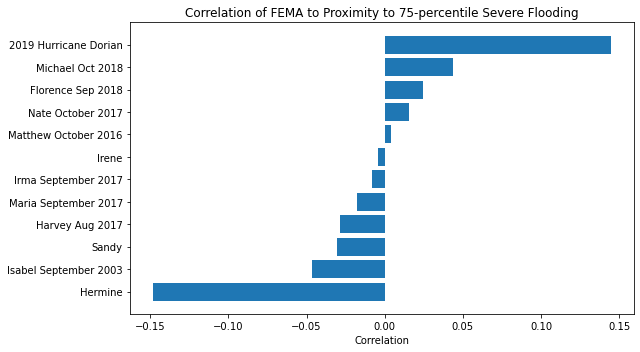

In [189]:
plt.figure(figsize = (9, 5))
plt.barh(corr_75.index, corr_75.values)
plt.title('Correlation of FEMA to Proximity to 75-percentile Severe Flooding')
plt.xlabel('Correlation')
plt.tight_layout()
plt.savefig('images/severe_prox_75.jpg');

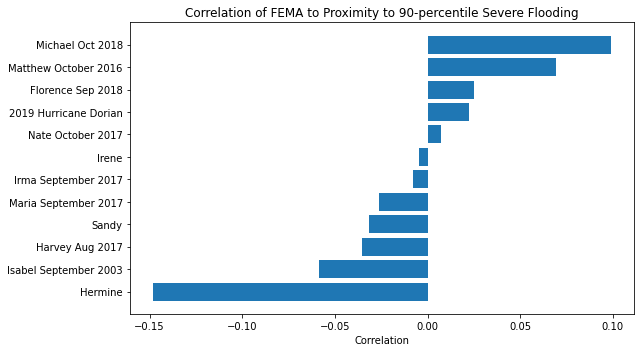

In [190]:
plt.figure(figsize = (9, 5))
plt.barh(corr_90.index, corr_90.values)
plt.title('Correlation of FEMA to Proximity to 90-percentile Severe Flooding')
plt.xlabel('Correlation')
plt.tight_layout()
plt.savefig('images/severe_prox_90.jpg');

In [199]:
for event in corr_90.index:
    if corr_90[event] > 0 and corr_75[event] > 0:
        print(event, np.round(corr_75[event],2) + np.round(corr_90[event], 2))

Nate October 2017 0.03
2019 Hurricane Dorian 0.16
Florence Sep 2018 0.05
Matthew October 2016 0.07
Michael Oct 2018 0.14
